## Load libraries

In [1]:
# tensorflow backend
from os import environ
environ['KERAS_BACKEND'] = 'tensorflow'
# vae stuff
from chemvae.vae_utils import VAEUtils
from chemvae import mol_utils as mu
# import scientific py
import numpy as np
import pandas as pd
# rdkit stuff
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import MolFromSmiles
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.
c:\Users\Carol He\miniconda3\envs\chemvae\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Carol He\miniconda3\envs\chemvae\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Carol He\miniconda3\envs\chemvae\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\Carol He\miniconda3\

# Load a model

In [2]:
vae = VAEUtils(directory='..\models\\np_properties')

From c:\Users\Carol He\miniconda3\envs\chemvae\lib\site-packages\keras\backend\tensorflow_backend.py:1210: calling reduce_prod (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
c:\Users\Carol He\miniconda3\envs\chemvae\lib\site-packages\keras\models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
From c:\Users\Carol He\miniconda3\envs\chemvae\lib\site-packages\keras\backend\tensorflow_backend.py:1192: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
From c:\Users\Carol He\miniconda3\envs\chemvae\lib\site-packages\keras\backend\tensorflow_backend.py:1156: calling reduce_max (fr

Using standarized functions? True
Standarization: estimating mu and std values ...done!


# Using the VAE


## Decode/Encode 

Might not be perfect (it's probabilistic), try it several times.

smiles <i class="fa fa-arrow-right" aria-hidden="true"></i> x <i class="fa fa-arrow-right" aria-hidden="true"></i> z <i class="fa fa-arrow-right" aria-hidden="true"></i> x_r <i class="fa fa-arrow-right" aria-hidden="true"></i> smiles_r

In [3]:
# smiles_1 = mu.canon_smiles('CSCC(=O)NNC(=O)c1c(C)oc(C)c1C')
smiles_1 = mu.canon_smiles('CCCCCCCCCCCC(=O)N[C@H]1CCOC1=O')

X_1 = vae.smiles_to_hot(smiles_1,canonize_smiles=True)
z_1 = vae.encode(X_1)
X_r= vae.decode(z_1)

print('{:20s} : {}'.format('Input',smiles_1))
print('{:20s} : {}'.format('Reconstruction',vae.hot_to_smiles(X_r,strip=True)[0]))

print('{:20s} : {} with norm {:.3f}'.format('Z representation',z_1.shape, np.linalg.norm(z_1)))

Input                : CCCCCCCCCCCC(=O)N[C@H]1CCOC1=O
Reconstruction       : COCccccCCCC(=C1(1c(Sc](=O)O
Z representation     : (1, 196) with norm 10.196


## property preditor

In [4]:
print('Properties (qed,SAS,logP):')
y_1 = vae.predict_prop_Z(z_1)[0]
print(y_1)

Properties (qed,SAS,logP):
[0.597775  3.1414762 2.0010486]


## Decode several attempts
VAE are probabilistic

Searching molecules randomly sampled from 5.00 std (z-distance) from the point
Z (1000, 196)
X (1000, 120, 35)
smiles 1000
smiles mol ['C=C(=CC/COc(O[=O1(  =)C1]H', 'CCC(C)BHC3OO1O)C cc2c[', 'CC1ccC(O1cOc(OC()CC]12=O)C2', 'CCC=CC/c(C(C2C(O]()2C', 'CCC/CC)c]c1O)C)[C)C          =']
before fast_verify 1000
                                 smiles  count
0            C=C(=CC/COc(O[=O1(  =)C1]H      1
1                CCC(C)BHC3OO1O)C cc2c[      1
2           CC1ccC(O1cOc(OC()CC]12=O)C2      1
3                 CCC=CC/c(C(C2C(O]()2C      1
4        CCC/CC)c]c1O)C)[C)C          =      1
..                                  ...    ...
995  CCC1Cc]O#CC(C(C(C1ccH2)          )      1
996              CCCC1c22c(C)oc(C(N 21=      1
997         CCC1Oc(=C@/)c(OCCC]1c(C)c[C      1
998       C#c1CC/cN(C(1OBcc1C(OC()O   c      1
999           Cc1ccc1[CC[C)C=CC(=)O)O=O      1

[1000 rows x 2 columns]
after fast_verify 49
                                                smiles  count
26                     

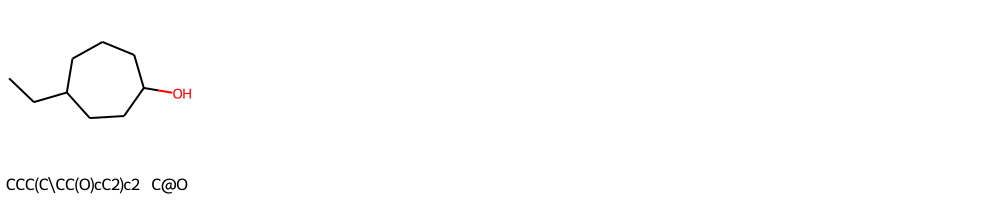

,smiles,distance,count,frequency,mol
0,CCC(C\CC(O)cC2)c2 C@O,11.822368,1,1.0,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [5]:
noise=5.0
print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))
df = vae.z_to_smiles( z_1,decode_attempts=1000,noise_norm=noise)
print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
print('SMILES\n',df.smiles)
display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='smiles',molsPerRow=5))
df.head()

**Validity:** 1 / 1000 * 100% = 0.1%

**Diversity:** 1 / 1000 * 100% = 0.1%

## Reconstruction Accuracy

In [ ]:
def compute_recon_quality(x, x_hat):
    # Get indices of maximum values along the last axis (vocab_size)
    x_indices = np.argmax(x, axis=2).flatten()
    x_hat_indices = np.argmax(x_hat, axis=2).flatten()

    # Compute differences and clamp between 0 and 1
    differences = 1.0 - np.abs(x_hat_indices - x_indices)
    differences = np.clip(differences, 0.0, 1.0)

    # Compute mean quality
    quality = 100.0 * np.mean(differences)

    return quality, differences

with open("np_5k.txt", 'r') as f:
    smiles_list = [line.strip() for line in f.readlines()]

quality_list = []
recon_smiles_list = []
batch = []
out_one_hot = []

for smiles in smiles_list:
    canon_smiles = mu.canon_smiles(smiles)
    X_1 = vae.smiles_to_hot(smiles_1,canonize_smiles=True)
    z_1 = vae.encode(X_1)
    X_r= vae.decode(z_1)
    recon_smiles = vae.hot_to_smiles(X_r,strip=True)[0]
    recon_smiles_list.append(recon_smiles)
    batch.append(X_1)
    out_one_hot.append(X_r)
    print(len(batch), "/5000")

quality, differences = compute_recon_quality(batch, out_one_hot)

1 /5000
2 /5000
3 /5000
4 /5000
5 /5000
6 /5000
7 /5000
8 /5000
9 /5000
10 /5000
11 /5000
12 /5000
13 /5000
14 /5000
15 /5000
16 /5000
17 /5000
18 /5000
19 /5000
20 /5000
21 /5000
22 /5000
23 /5000
24 /5000
25 /5000
26 /5000
27 /5000
28 /5000
29 /5000
30 /5000
31 /5000
32 /5000
33 /5000
34 /5000
35 /5000
36 /5000
37 /5000
38 /5000
39 /5000
40 /5000
41 /5000
42 /5000
43 /5000
44 /5000
45 /5000
46 /5000
47 /5000
48 /5000
49 /5000
50 /5000
51 /5000
52 /5000
53 /5000
54 /5000
55 /5000
56 /5000
57 /5000
58 /5000
59 /5000
60 /5000
61 /5000
62 /5000
63 /5000
64 /5000
65 /5000
66 /5000
67 /5000
68 /5000
69 /5000
70 /5000
71 /5000
72 /5000
73 /5000
74 /5000
75 /5000
76 /5000
77 /5000
78 /5000
79 /5000
80 /5000
81 /5000
82 /5000
83 /5000
84 /5000
85 /5000
86 /5000
87 /5000
88 /5000
89 /5000
90 /5000
91 /5000
92 /5000
93 /5000
94 /5000
95 /5000
96 /5000
97 /5000
98 /5000
99 /5000
100 /5000
101 /5000
102 /5000
103 /5000
104 /5000
105 /5000
106 /5000
107 /5000
108 /5000
109 /5000
110 /5000
111 /500

In [15]:
quality, differences

(61.44, array([1., 0., 0., ..., 1., 1., 0.]))

**Reconstruction Accuracy:** 61.44%

## PCA of latent space

Sample random points from the training set along with properties

In [6]:
Z, data, smiles = vae.ls_sampler_w_prop(size=5000,return_smiles=True)
prop_opt = 'qed'
prop_df = pd.DataFrame(data).reset_index()
prop_df['smiles']=smiles
prop_df.head()

,index,logP,qed,SAS,smiles
0,9321,2.2791,0.731344,4.220149,CN1CC2(C)OC2C2c3cccc4[nH]cc(c34)CC21
1,1299,2.0832,0.569693,6.290609,C=C1[C@H](O)[C@H]2O[C@@]23[C@@H]1C[C@]12CC[C@H...
2,5470,2.5869,0.500642,4.020933,C/C=C/C=C/C[C@@H](O)[C@@H](O)CC/C=C/C
3,5464,1.6422,0.279519,3.882772,C[C@@H]1OC(=O)c2c(O)cc(O)c(O)c2[C@@H]1Cl
4,9091,1.5257,0.374512,7.013232,CC(=O)O[C@H]1[C@]2(OC(C)=O)C[C@]34SSSS[C@](CO)...


Perform a PCA projection and color the points based on a property

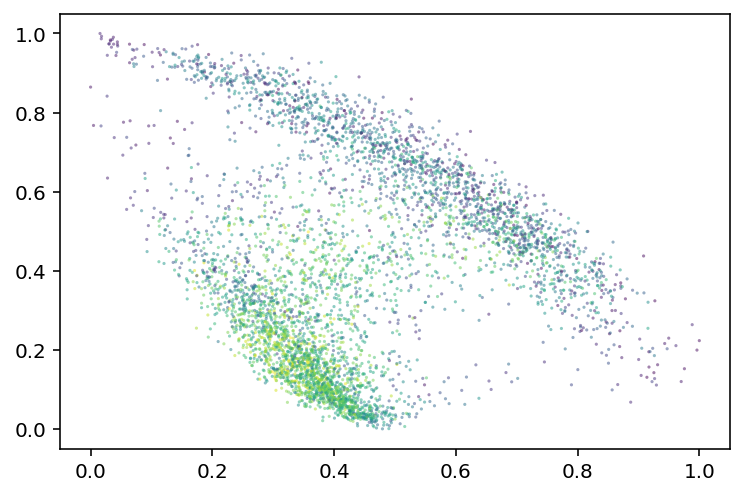

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# do pca and normalize
Z_pca = PCA(n_components=2).fit_transform(Z)
Z_pca = MinMaxScaler().fit_transform(Z_pca)

df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']
df[prop_opt]=prop_df[prop_opt]

plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.show()

compare with t-SNE, will take some time

In [ ]:
from sklearn.manifold import TSNE

Z_tsne = TSNE(n_components=2).fit_transform(Z)
Z_tsne = MinMaxScaler().fit_transform(Z_tsne)

f = pd.DataFrame(np.transpose((Z_tsne[:,0],Z_tsne[:,1])))
df.columns = ['x','y']
df[prop_opt]=prop_df[prop_opt]

plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.show()